# Brazilian-Tweet-Sentiment-Analysis using ELECTRA BASE
This is an ELECTRA - Base approach to Protuguese tweets sentiment analysis task, an [Open Contest in Kaggle](https://www.kaggle.com/competitions/TweetSentimentBR/overview).

## Model Selection

I  select ELECTRA Base for familiarity reasons with the model implementation as a first attemp to the contest. Also I selected the model because its similitudes with GAN architecture relying in the discriminator than the generator and his low cost architecture.

In fact, when purpoused, these was the main reasons that highlight the model.

## Architecture

I trainend the overall model using a Google Colab Pro Instance using a T4 GPU instance.

## Common Imports

We need basic requirements including torch, pandas, and wordcloud.

In [ ]:
!pip install pandas tqdm
!pip install wordcloud

## Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Verifying if the conection was succesfull.

In [ ]:
!ls
!pwd

drive  sample_data
/content


Important Note: You need to create the structure of the repository in our Drive to avoid errors.

## Importing base libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch
from transformers import ElectraTokenizer, ElectraForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from tqdm import tqdm
import time
import torch
import numpy as np
from wordcloud import WordCloud
import json

from collections import deque
sns.set()

Verifying cuda is available.

In [ ]:
torch.cuda.is_available()

True

## Dataset Analysis

### Importing the dataset from source

In [ ]:
PATH_REPO = "/content/drive/MyDrive/Repos/Brazilian-Tweet-Sentiment-Analysis"

In [ ]:
df = pd.read_csv(f'{PATH_REPO}/data/Train.csv')
df

,id,tweet_text,tweet_date,sentiment,query_used
0,1049158578504916992,@Vini_Arisato eu espero que não,Mon Oct 08 04:44:32 +0000 2018,0,:(
1,1049104603332169728,me diz aí o que vai ser do serviço social com ...,Mon Oct 08 01:10:03 +0000 2018,1,:)
2,1050780236856651776,"inclusive, os nomes que eu uso aqui são de tes...",Fri Oct 12 16:08:25 +0000 2018,1,:)
3,1047555890654728192,@rangerlol1 Hora da panelinha começar a passar...,Wed Oct 03 18:36:01 +0000 2018,1,:)
4,1046965203701829632,Meu neosoro tá acabando,Tue Oct 02 03:28:50 +0000 2018,0,:(
...,...,...,...,...,...
49995,1048388839142776832,Qual fic super boa que vc tá lendo? Indica aí ...,Sat Oct 06 01:45:52 +0000 2018,1,:)
49996,1046928181696126978,@BaptistaIsinha @lovelyoldmagcon @lovoitnb inc...,Tue Oct 02 01:01:44 +0000 2018,0,:(
49997,1046985016784429058,a faculdade te muda pra pior,Tue Oct 02 04:47:34 +0000 2018,0,:(
49998,1050763799509291008,@dbxlro bola de futebol a chamar me de gordo ?...,Fri Oct 12 15:03:06 +0000 2018,1,:)


In [ ]:
test_df = pd.read_csv(f'{PATH_REPO}/data/Test.csv')
test_df

,id,tweet_text,tweet_date
0,1029570266916159488,@Ataylandia vc paga o meu e eu como o seu tau...,Wed Aug 15 03:27:34 +0000 2018
1,1030496040649142272,a mão ((((((( https://t.co/cdBTzTVCt6,Fri Aug 17 16:46:16 +0000 2018
2,1030496928755314688,@delucca geralmente a depressão é filha da ans...,Fri Aug 17 16:49:48 +0000 2018
3,1029559076815097856,SUPER INDICO!!! GRANDE PROFISSIONAL https://t...,Wed Aug 15 02:43:06 +0000 2018
4,1029551213866573830,@Leticia75917877 Boa sorte,Wed Aug 15 02:11:52 +0000 2018
...,...,...,...
4995,1030520190151340033,"@xbtsbabes Sim!!! Eu faço, mas dá tudo errado ...",Fri Aug 17 18:22:14 +0000 2018
4996,1029546296087130112,"@brendspl Capazz, mas obrigado, lisongeado )",Wed Aug 15 01:52:19 +0000 2018
4997,1030502469615403008,@juulianaalindaa podia ser a do luxemburgo ( m...,Fri Aug 17 17:11:49 +0000 2018
4998,1030510914045390849,@jiminevil anão agora tô triste pq esqueceram ...,Fri Aug 17 17:45:22 +0000 2018


### Filtering to-use columns

In [ ]:
df = df[['tweet_text', 'sentiment']]
df

,tweet_text,sentiment
0,@Vini_Arisato eu espero que não,0
1,me diz aí o que vai ser do serviço social com ...,1
2,"inclusive, os nomes que eu uso aqui são de tes...",1
3,@rangerlol1 Hora da panelinha começar a passar...,1
4,Meu neosoro tá acabando,0
...,...,...
49995,Qual fic super boa que vc tá lendo? Indica aí ...,1
49996,@BaptistaIsinha @lovelyoldmagcon @lovoitnb inc...,0
49997,a faculdade te muda pra pior,0
49998,@dbxlro bola de futebol a chamar me de gordo ?...,1


### Wordcloud of Non-Processed Text

Both word clouds are nearly identical because we decided not to preprocess using libraries such as NLTK. We only filtered punctuation and converted the text to lowercase.

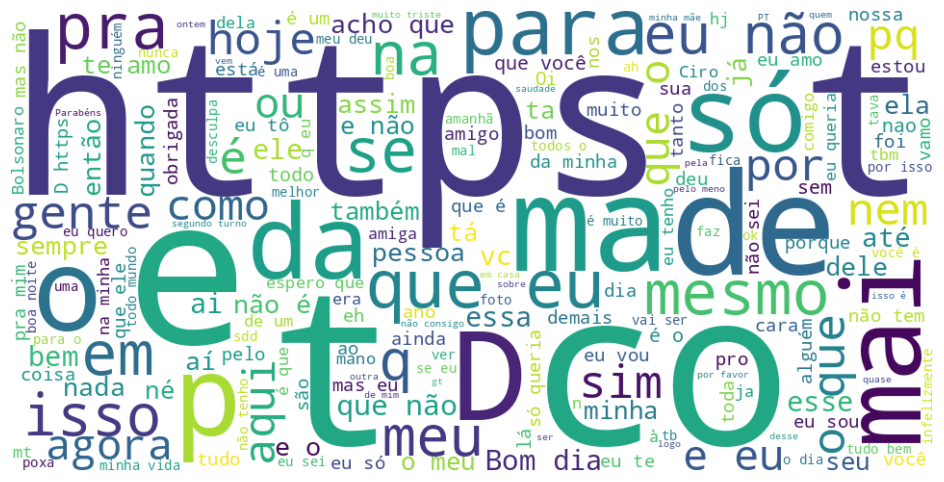

In [ ]:
plt.figure(figsize=(12, 6))

text = " ".join(list(df['tweet_text']))

wordcloud = WordCloud(width=960, height=480, background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')


plt.savefig(f'{PATH_REPO}/figures/Wordcloud_of_not_processed_text.png')
plt.show()

In [ ]:
word_count = df['tweet_text'].apply(lambda x: len(list(x.split())))
print("Max word count in crude texts:", max(word_count))

Max word count in crude texts: 64


### Word Count Distribution Histogram

The plot shows that most of the text falls within the 1-100 word count range, which is perfect for our model with a maximum of 128 tokens.

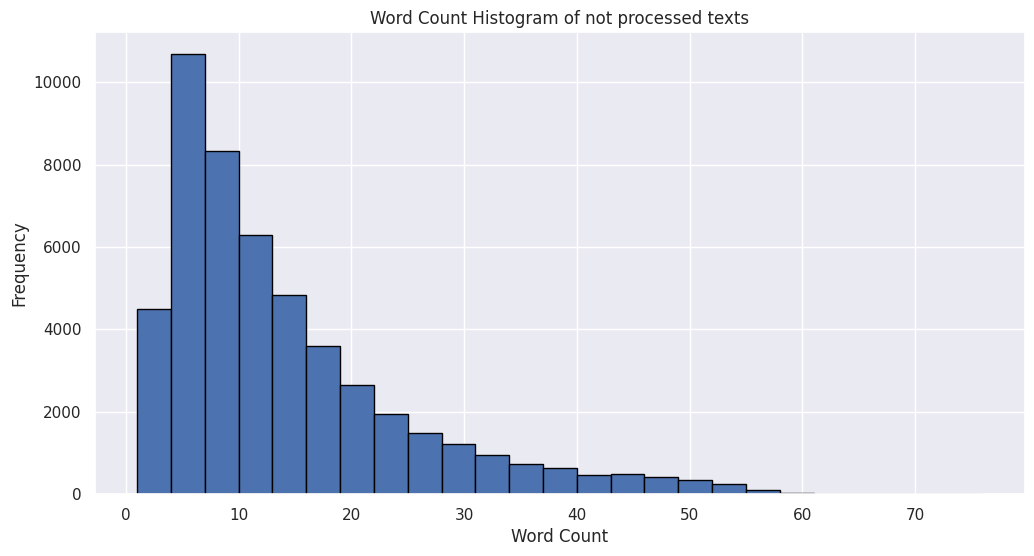

In [ ]:
plt.figure(figsize=(12, 6))

plt.hist(word_count, bins=range(min(word_count), max(word_count) + 15, 3), edgecolor='black')

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Histogram of not processed texts')
plt.savefig(f'{PATH_REPO}/figures/Histogram_Word_count_not_processed.png')
plt.show()

### Label Distribution

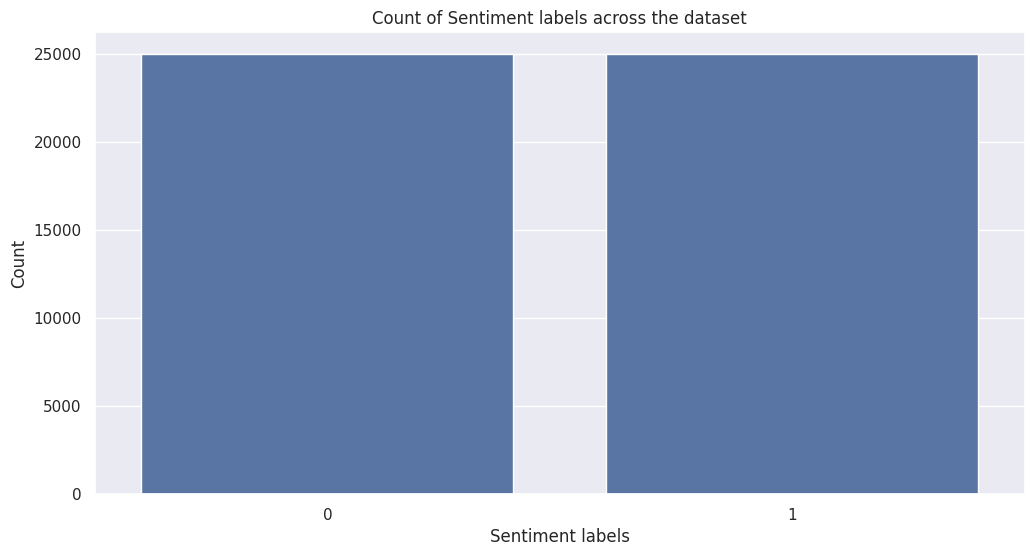

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='sentiment', data=df)
plt.xlabel("Sentiment labels")
plt.ylabel("Count")
plt.title("Count of Sentiment labels across the dataset")
plt.savefig(f'{PATH_REPO}/figures/Count_of_sentiment_labels_across_the_dataset.png')
plt.show()


In [ ]:
df.dtypes

tweet_text    object
sentiment      int64
dtype: object

### Text preprocessing

For preprocessing as I am studying portuguese I know several terms which some words as mentions could be replaced. Then I start to deleting puntuation and numbers.

In [ ]:
def tweet_to_portuguese_text(text):
    ans = ''
    first_mention, first_url = True, True
    for word in list(text.split(' ')):
        if len(word) <= 1:
            continue
        if word[0] == '@':
            if first_mention:
                first_mention = False
                ans += 'Você '
            else:
                ans += 'ele '
        elif word[:4] == 'http':
            if first_url:
                first_url = False
                ans += 'veja este url '
            else:
                pass

        elif word[0] in '0123456789':
            if len(word) > 1:
                ans += 'muitos '
            else:
                ans += 'poucos '
        else:
            ans += word + ' '
    return ans[:-1]

In [ ]:
def clean_extra_numbers(text):
    ans = ''
    for elem in text:
        if not elem in '0123456789':
            ans += elem
    return ans

In [ ]:
df = df[['tweet_text', 'sentiment']]
df['tweet_text'] = df['tweet_text'].apply(tweet_to_portuguese_text)
df['tweet_text'] = df['tweet_text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())
df['tweet_text'] = df['tweet_text'].apply(clean_extra_numbers)
df.head()

,tweet_text,sentiment
0,você eu espero que não,0
1,me diz aí que vai ser do serviço social com bo...,1
2,inclusive os nomes que eu uso aqui são de test...,1
3,você hora da panelinha começar passar pano fal...,1
4,meu neosoro tá acabando,0


In [ ]:
df['tweet_text'] = df['tweet_text'].apply(tweet_to_portuguese_text)
test_df['tweet_text'] = test_df['tweet_text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())
test_df['tweet_text'] = test_df['tweet_text'].apply(clean_extra_numbers)
test_df.head()

,id,tweet_text,tweet_date
0,1029570266916159488,ataylandia vc paga o meu e eu como o seu taua...,Wed Aug 15 03:27:34 +0000 2018
1,1030496040649142272,a mão httpstcocdbtztvct,Fri Aug 17 16:46:16 +0000 2018
2,1030496928755314688,delucca geralmente a depressão é filha da ansi...,Fri Aug 17 16:49:48 +0000 2018
3,1029559076815097856,super indico grande profissional httpstcoehui...,Wed Aug 15 02:43:06 +0000 2018
4,1029551213866573830,leticia boa sorte,Wed Aug 15 02:11:52 +0000 2018


### Wordcloud of Processed Text

As mentioned, due to the preprocessing, there is notorious change with the previous wordcloud. This remarks the preprocessing was successfull.

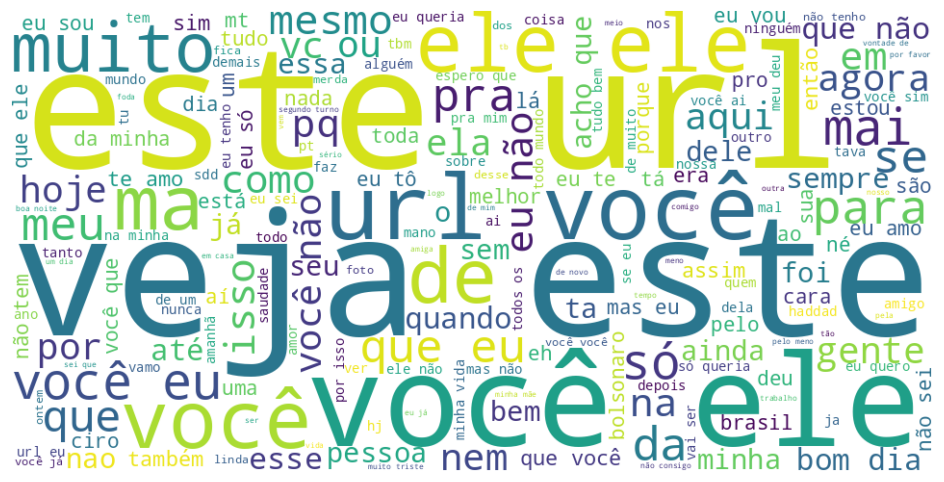

In [ ]:
plt.figure(figsize=(12, 6))

text = " ".join(list(df['tweet_text']))

wordcloud = WordCloud(width=960, height=480, background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')


plt.savefig(f'{PATH_REPO}/figures/Wordcloud_of_processed_text.png')
plt.show()

In [ ]:
word_count = df['tweet_text'].apply(lambda x: len(list(x.split())))
print("Max word count in preprocessed texts:", max(word_count))

Max word count in preprocessed texts: 59


### Distribution of Post-Processed Text Histogram

Even though the maximum number of words may change, the word distribution remains almost the same after preprocessing.

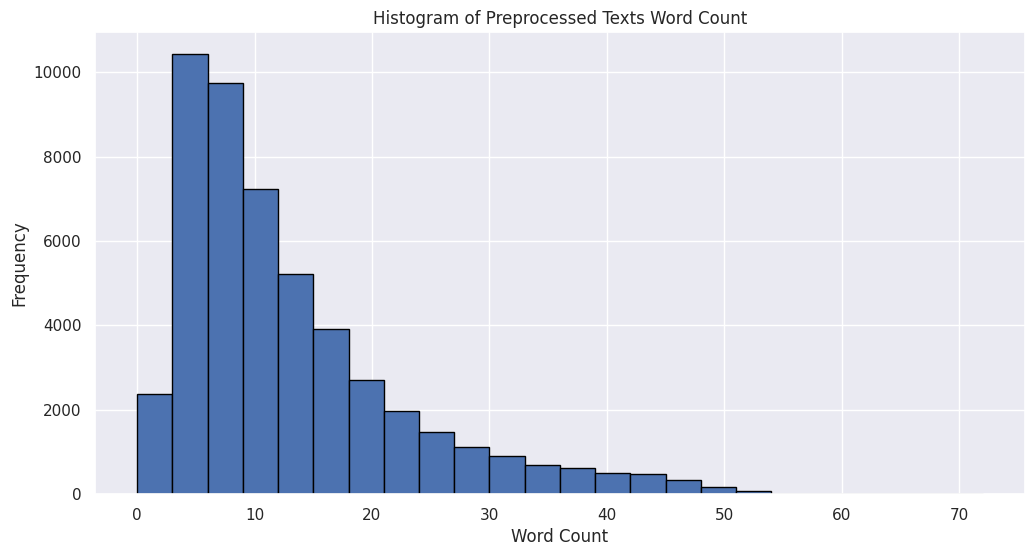

In [ ]:
plt.figure(figsize=(12, 6))

plt.hist(word_count, bins=range(min(word_count), max(word_count) + 15, 3), edgecolor='black')

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Preprocessed Texts Word Count')
plt.savefig(f'{PATH_REPO}/figures/Word_Count_Histogram_Preprocessed_texts.png')
plt.show()

## Model Building

First, we'll separate the data into a training set and a valid set, with a split of 90/10%. Then, we'll create some classes for data and model handling.

## Model Selection

I selected ELECTRA because of the similarities with the GAN-based models architecture, relying in a discriminator step which improves the performance. The model also relies in low cost architecture which brings me the oportunity to improve at most the GPU memory usage.

In [ ]:
# df = df.head(50) # This cell is mainly used to run a beta of the model with the goal to see everything is working without problems.

In [ ]:
X = df[['tweet_text']]
y = df['sentiment']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
class TransformerModel:
  def __init__(self, tokenizer_class, tokenizer_name, model_class, model_name):
    self.batch_size = 64
    self.max_length = 128
    self.num_epochs = 15
    self.learning_rate = 4e-5
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.tokenizer = tokenizer_class.from_pretrained(tokenizer_name)
    self.model = model_class.from_pretrained(model_name).to(self.device)
    self.optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)


  def create_dataloader(self, texts, labels):
    dataset = CustomDataset(list(texts), list(labels), self.tokenizer, self.max_length)
    return DataLoader(dataset, batch_size=self.batch_size)

  def fit(self, train_loader, valid_loader):
    self.train_loss_list = list()
    self.valid_loss_list = list()
    valid_loss_history = deque(maxlen=3)
    best_score = float('inf')
    best_epoch = 0

    for epoch in range(self.num_epochs):
      ### Training
      self.model.train()
      total_loss = 0
      for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}', leave=False):
          self.optimizer.zero_grad()

          input_ids = batch['input_ids'].to(self.device)
          attention_mask = batch['attention_mask'].to(self.device)
          labels = batch['labels'].to(self.device)

          outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)

          loss = outputs.loss
          total_loss += loss.item()

          loss.backward()
          self.optimizer.step()
      avg_loss = total_loss / len(train_loader)
      print("Training Loss", avg_loss)
      self.train_loss_list.append(avg_loss)
      self.model.save_pretrained(f'{PATH_REPO}/models/old/ebase-disaster-epoch-{epoch + 1}/')

      ### Validation
      self.model.eval()
      total_valid_loss = 0
      with torch.no_grad():
          for batch in  tqdm(valid_loader):
              input_ids = batch['input_ids'].to(self.device)
              attention_mask = batch['attention_mask'].to(self.device)
              labels = batch['labels'].to(self.device)

              outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
              loss = outputs.loss
              total_valid_loss += loss.item()

      avg_valid_loss = total_valid_loss / len(valid_loader)
      if best_score > avg_valid_loss:
          best_score = avg_valid_loss + 0
          self.model.save_pretrained(f'{PATH_REPO}/models/Best_model/')
          best_epoch = epoch + 1
      print("Validation loss", avg_valid_loss)
      self.valid_loss_list.append(avg_valid_loss)

      valid_loss_history.append(avg_valid_loss)

      if len(valid_loss_history) == valid_loss_history.maxlen:
          if all(valid_loss_history[i] < valid_loss_history[i+1] for i in range(len(valid_loss_history) - 1)):
              print("Early stopping: Validation loss no longer decreasing.")
              break
    loss_df = pd.DataFrame()
    loss_df["train_loss"] = self.train_loss_list
    loss_df["valid_loss"] = self.valid_loss_list
    loss_df.to_csv(f'{PATH_REPO}/results/loss_history.csv', index=False)
    print(f'Best epoch: {best_epoch} with score {best_score}')



  def predict(self, texts):
    predictions = []
    for text in tqdm(list(texts)):
        inputs = self.tokenizer(text,
                                return_tensors='pt',
                                max_length=self.max_length,
                                truncation=True,
                                padding='max_length')

        inputs = {key: value.to(self.device) for key, value in inputs.items()}
        outputs = self.model(**inputs)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()
        predictions.append(predicted_label)
    return predictions

  def score(self, texts, y):
    preds = self.predict(texts)
    return f1_score(y, preds)

### Model Creation

For this step, we will utilize our previous class "TransformerModel."

In [ ]:
ebase = TransformerModel(ElectraTokenizer,
                          'google/electra-base-discriminator',
                          ElectraForSequenceClassification,
                          'google/electra-base-discriminator')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Model Training

The parameters used for this training are specified in the base class we created by default. They are as follows:

* Batch size: 64.
* Max Length: 128.
* Number of epochs: 30.
* Learning Rate: 4e-5

In [ ]:
print("Creating Dataloader")
dataloader_train = ebase.create_dataloader(X_train['tweet_text'], y_train)
dataloader_val = ebase.create_dataloader(X_val['tweet_text'], y_val)
print("Training model")
ebase.fit(dataloader_train, dataloader_val)
print("Ending")

Creating Dataloader
Training model


Training Loss 0.5652452444827015


100%|██████████| 79/79 [00:39<00:00,  1.99it/s]


Validation loss 0.49449256741547887


Training Loss 0.46837828486141836


100%|██████████| 79/79 [00:39<00:00,  2.01it/s]


Validation loss 0.48408721293075174


Training Loss 0.4223751869602976


100%|██████████| 79/79 [00:39<00:00,  2.02it/s]


Validation loss 0.49440881949436816


Training Loss 0.3657143560968424


100%|██████████| 79/79 [00:39<00:00,  2.02it/s]


Validation loss 0.5337372271320487
Early stopping: Validation loss no longer decreasing.
Best epoch: 2 with score 0.48408721293075174
Ending


### Model Evaluation

For this evaluation, after saving the losses of all epochs, I will plot it in a line plot by epoch.

As you ca see in the next figure, the best achieved loss was obtain in epoch 2. As we set early stopping step, the model stops at epoch 4.

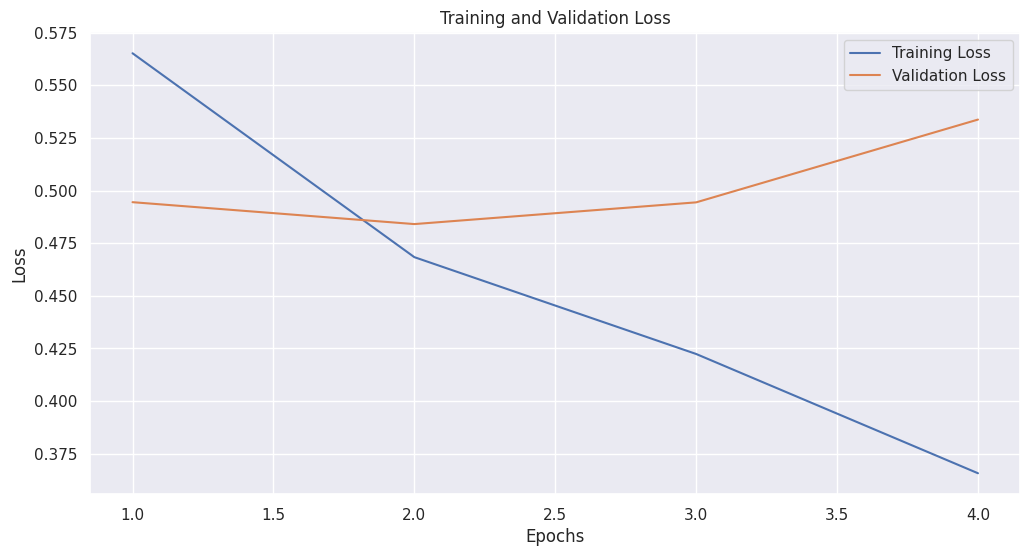

In [ ]:
loss_history = pd.read_csv(f'{PATH_REPO}/results/loss_history.csv')

loss_train = list(loss_history['train_loss'])
loss_valid = list(loss_history['valid_loss'])

epochs = range(1, len(loss_train) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_train, label='Training Loss')
plt.plot(epochs, loss_valid, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.grid(True)
plt.savefig(f'{PATH_REPO}/figures/Training and Validation Loss.png')

plt.show()

In [ ]:
del ebase

In [ ]:
ebase = TransformerModel(ElectraTokenizer,
                          'google/electra-base-discriminator',
                          ElectraForSequenceClassification,
                          'google/electra-base-discriminator')

ebase.model = ElectraForSequenceClassification.from_pretrained(f'{PATH_REPO}/models/Best_model/').to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
test_df['sentiment'] = ebase.predict(test_df['tweet_text'])
test_df

100%|██████████| 5000/5000 [01:11<00:00, 69.92it/s]


,id,tweet_text,tweet_date,sentiment
0,1029570266916159488,ataylandia vc paga o meu e eu como o seu taua...,Wed Aug 15 03:27:34 +0000 2018,1
1,1030496040649142272,a mão httpstcocdbtztvct,Fri Aug 17 16:46:16 +0000 2018,1
2,1030496928755314688,delucca geralmente a depressão é filha da ansi...,Fri Aug 17 16:49:48 +0000 2018,0
3,1029559076815097856,super indico grande profissional httpstcoehui...,Wed Aug 15 02:43:06 +0000 2018,1
4,1029551213866573830,leticia boa sorte,Wed Aug 15 02:11:52 +0000 2018,1
...,...,...,...,...
4995,1030520190151340033,xbtsbabes sim eu faço mas dá tudo errado essa...,Fri Aug 17 18:22:14 +0000 2018,0
4996,1029546296087130112,brendspl capazz mas obrigado lisongeado,Wed Aug 15 01:52:19 +0000 2018,1
4997,1030502469615403008,juulianaalindaa podia ser a do luxemburgo mis...,Fri Aug 17 17:11:49 +0000 2018,1
4998,1030510914045390849,jiminevil anão agora tô triste pq esqueceram d...,Fri Aug 17 17:45:22 +0000 2018,0


In [ ]:
test_df['sentiment'].value_counts()

sentiment
1    2647
0    2353
Name: count, dtype: int64

In [ ]:
ans_df = test_df[['id', 'sentiment']]
ans_df

,id,sentiment
0,1029570266916159488,1
1,1030496040649142272,1
2,1030496928755314688,0
3,1029559076815097856,1
4,1029551213866573830,1
...,...,...
4995,1030520190151340033,0
4996,1029546296087130112,1
4997,1030502469615403008,1
4998,1030510914045390849,0


## Saving the submission file

Then I save the results in a fixed path in my drive.

In [ ]:
ans_df.to_csv(f'{PATH_REPO}/data/answer.csv', index=False)

## Conclusions and Future Work

In this notebook I trained an ELECTRA - BASE architecture for Brazilian Tweets Sentiment Analysis classification. The dataset was obtained in this [Open Kaggle Contest](https://www.kaggle.com/competitions/TweetSentimentBR/overview). I obtained the second place with an score of 0.72860 (At the moment to upload this notebook in GitHub). There is a long way to go.

In future works, I want to thest even deeper architectures with more epochs and smaller batch sizes.

In [ ]:
"Thats all folks"

'Thats all folks'